In [2]:
!pip install imbalanced-learn
!pip install shap

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_fscore_support)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
import joblib
try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    SMOTE = None
    smote_available = False

try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

print("SMOTE available:", smote_available, "SHAP available:", shap_available)

SMOTE available: True SHAP available: True


Load Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data-bank.csv")

In [6]:
data.head ()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [8]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [9]:
data.shape

(6819, 96)

Quick data understanding

In [10]:
# Detect target column (expected 'Bankrupt?')
target = 'Bankrupt?' if 'Bankrupt?' in data.columns else None
if target is None:
    # choose first binary column as fallback
    for c in data.columns:
        if data[c].nunique() <= 2:
            target = c
            break
if target is None:
    raise ValueError("Cannot detect target column automatically. Set `target` manually.")
print("Using target:", target)
print(data[target].value_counts(dropna=False))

Using target: Bankrupt?
Bankrupt?
0    6599
1     220
Name: count, dtype: int64


In [11]:
# Numeric features
num = data.select_dtypes(include=[np.number])
print("Numeric feature count:", num.shape[1])

Numeric feature count: 96


In [12]:
print("=== BANKRUPTCY STATUS OVERVIEW ===")
total_records = len(data)
bankrupt_count = data[target].sum()
not_bankrupt_count = total_records - bankrupt_count
bankrupt_percentage = (bankrupt_count / total_records) * 100
not_bankrupt_percentage = (not_bankrupt_count / total_records) * 100

print(f"Total banks analyzed: {total_records}")
print(f"Bankrupt banks (corrupt): {bankrupt_count} ({bankrupt_percentage:.2f}%)")
print(f"Healthy banks: {not_bankrupt_count} ({not_bankrupt_percentage:.2f}%)")


=== BANKRUPTCY STATUS OVERVIEW ===
Total banks analyzed: 6819
Bankrupt banks (corrupt): 220 (3.23%)
Healthy banks: 6599 (96.77%)


/tmp/ipython-input-2414609459.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=status_counts.values, palette=['#A8E6CF', '#FF8B94'])


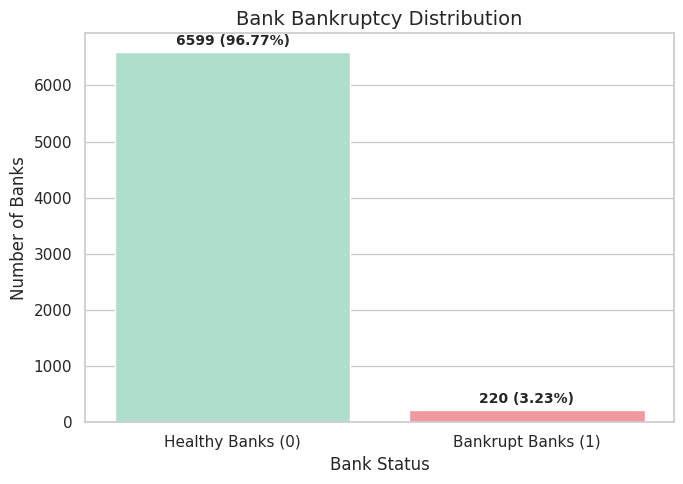

In [13]:
# Bar chart visualization
status_counts = data[target].value_counts().sort_index()
labels = ['Healthy Banks (0)', 'Bankrupt Banks (1)']
percentages = [not_bankrupt_percentage, bankrupt_percentage]

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=status_counts.values, palette=['#A8E6CF', '#FF8B94'])
plt.title('Bank Bankruptcy Distribution', fontsize=14)
plt.xlabel('Bank Status', fontsize=12)
plt.ylabel('Number of Banks', fontsize=12)

# Annotate bar with count and percentage
for i, (count, pct) in enumerate(zip(status_counts.values, percentages)):
    plt.text(i, count + total_records*0.01, f'{count} ({pct:.2f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


EDA

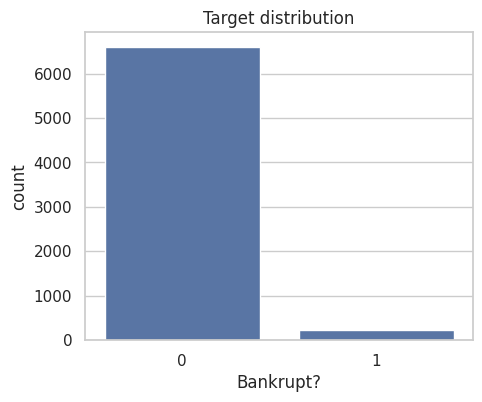

,count,mean,std,min,25%,50%,75%,max
Bankrupt?,6819.0,3.226280e-02,1.767102e-01,0.0,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
ROA(C) before interest and depreciation before interest,6819.0,5.051796e-01,6.068564e-02,0.0,0.476527,5.027056e-01,5.355628e-01,1.000000e+00
ROA(A) before interest and % after tax,6819.0,5.586249e-01,6.562003e-02,0.0,0.535543,5.598016e-01,5.891572e-01,1.000000e+00
ROA(B) before interest and depreciation after tax,6819.0,5.535887e-01,6.159481e-02,0.0,0.527277,5.522780e-01,5.841051e-01,1.000000e+00
Operating Gross Margin,6819.0,6.079480e-01,1.693381e-02,0.0,0.600445,6.059975e-01,6.139142e-01,1.000000e+00
Realized Sales Gross Margin,6819.0,6.079295e-01,1.691607e-02,0.0,0.600434,6.059759e-01,6.138421e-01,1.000000e+00
Operating Profit Rate,6819.0,9.987551e-01,1.301003e-02,0.0,0.998969,9.990222e-01,9.990945e-01,1.000000e+00
Pre-tax net Interest Rate,6819.0,7.971898e-01,1.286899e-02,0.0,0.797386,7.974636e-01,7.975788e-01,1.000000e+00
After-tax net Interest Rate,6819.0,8.090836e-01,1.360065e-02,0.0,0.809312,8.093752e-01,8.094693e-01,1.000000e+00
Non-industry income and expenditure/revenue,6819.0,3.036229e-01,1.116344e-02,0.0,0.303466,3.035255e-01,3.035852e-01,1.000000e+00


Top correlations with target:
 Bankrupt?                               1.000000
 Debt ratio %                           0.250161
 Current Liability to Assets            0.194494
 Borrowing dependency                   0.176543
 Current Liability to Current Assets    0.171306
 Liability to Equity                    0.166812
 Current Liabilities/Equity             0.153828
 Current Liability to Equity            0.153828
 Liability-Assets Flag                  0.139212
 Total expense/Assets                   0.139049
Name: Bankrupt?, dtype: float64
Bottom correlations with target:
 Per Share Net profit before tax (Yuan ¥)                  -0.201395
Net profit before tax/Paid-in capital                     -0.207857
Retained Earnings to Total Assets                         -0.217779
Persistent EPS in the Last Four Seasons                   -0.219560
Net worth/Assets                                          -0.250161
ROA(C) before interest and depreciation before interest   -0.260807
ROA(B

In [14]:
plt.figure(figsize=(5,4))
sns.countplot(x=target, data=data)
plt.title("Target distribution")
plt.show()

display(data[num.columns].describe().transpose().iloc[:20])

# Correlation with target
corr_with_target = num.corr()[target].sort_values(ascending=False)
print("Top correlations with target:\n", corr_with_target.head(10))
print("Bottom correlations with target:\n", corr_with_target.tail(10))


Preprocessing

In [15]:
# Keep numeric features only (or encode categoricals if desired)
X = data.drop(columns=[target]).select_dtypes(include=[np.number]).copy()
y = data[target].astype(int).copy()

In [16]:
# Drop constant columns
const_selector = VarianceThreshold(threshold=0.0)
try:
    const_selector.fit(X)
    const_cols = X.columns[const_selector.variances_ <= 0.0].tolist()
except Exception:
    const_cols = [c for c in X.columns if X[c].nunique() <= 1]
if const_cols:
    X.drop(columns=const_cols, inplace=True)
    print("Dropped constant cols:", const_cols)

Dropped constant cols: [' Net Income Flag']


In [17]:
# Impute missing with median
X = X.fillna(X.median())

In [18]:
# Drop highly correlated features (threshold 0.95)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
if to_drop:
    print("Dropping highly correlated features (n={}): {}".format(len(to_drop), to_drop[:10]))
    X.drop(columns=to_drop, inplace=True)

Dropping highly correlated features (n=16): [' ROA(B) before interest and depreciation after tax', ' Realized Sales Gross Margin', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Per Share Net profit before tax (Yuan ¥)', ' Regular Net Profit Growth Rate', ' Net worth/Assets', ' Operating profit/Paid-in capital']


In [19]:
print("Final feature count:", X.shape[1])

Final feature count: 78


Train / Train Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts())

Train shape: (5455, 78) Test shape: (1364, 78)
Train class distribution:
 Bankrupt?
0    5279
1     176
Name: count, dtype: int64


Handle class imbalance

In [21]:
if smote_available:
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("Applied SMOTE. New train distribution:", pd.Series(y_train_res).value_counts().to_dict())
else:
    # bootstrap upsample minority in training set
    train_df = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
    majority_class = y_train.value_counts().idxmax()
    minority_class = y_train.value_counts().idxmin()
    majority = train_df[train_df[target] == majority_class]
    minority = train_df[train_df[target] == minority_class]
    minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    train_up = pd.concat([majority, minority_up])
    X_train_res = train_up.drop(columns=[target])
    y_train_res = train_up[target]
    print("Applied bootstrap upsampling. New train distribution:", y_train_res.value_counts().to_dict())

# Keep resampled sets in DataFrame form for potential SHAP / interpretation
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Applied SMOTE. New train distribution: {0: 5279, 1: 5279}


Scaling

In [22]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_res)
X_test_s = scaler.transform(X_test)


Baseline models + GridSearch (tuned)

In [24]:
# Use StratifiedKFold to keep class distribution in CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grids (kept small for speed; expand if you have time)
dt = DecisionTreeClassifier(random_state=42)
dt_params = {"max_depth": [4, 6, 8, 10], "min_samples_split": [2, 5, 10]}

rf = RandomForestClassifier(random_state=42)
rf_params = {"n_estimators": [100, 200], "max_depth": [6, 8, 10], "min_samples_split": [2, 5]}

mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp_params = {"hidden_layer_sizes": [(50,), (100,)], "alpha": [0.0001, 0.001]}

grids = {
    "DecisionTree": (dt, dt_params),
    "RandomForest": (rf, rf_params),
    "MLP": (mlp, mlp_params)
}

best_models = {}
for name, (estimator, params) in grids.items():
    print(f"GridSearchCV for {name} ...")
    g = GridSearchCV(estimator=estimator, param_grid=params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
    g.fit(X_train_s, y_train_res)
    best_models[name] = g.best_estimator_
    print(f" -> {name} best ROC AUC (CV): {g.best_score_:.4f}, best params: {g.best_params_}")


GridSearchCV for DecisionTree ...
 -> DecisionTree best ROC AUC (CV): 0.9589, best params: {'max_depth': 6, 'min_samples_split': 2}
GridSearchCV for RandomForest ...
 -> RandomForest best ROC AUC (CV): 0.9951, best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
GridSearchCV for MLP ...
 -> MLP best ROC AUC (CV): 0.9958, best params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}


Evaluation

In [25]:
def evaluate_model(name, model, X_test_s, y_test):
    y_pred = model.predict(X_test_s)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test_s)[:, 1]
    except Exception:
        pass
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, zero_division=0)
    print(f"\n{name} evaluation:")
    print("Accuracy:", acc)
    print("ROC AUC:", roc)
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", cr)
    return {"accuracy": acc, "roc_auc": roc, "cm": cm, "report": cr}

results = {}
for name, model in best_models.items():
    results[name] = evaluate_model(name, model, X_test_s, y_test)



DecisionTree evaluation:
Accuracy: 0.8826979472140762
ROC AUC: 0.8294077134986225
Confusion matrix:
 [[1175  145]
 [  15   29]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      1320
           1       0.17      0.66      0.27        44

    accuracy                           0.88      1364
   macro avg       0.58      0.77      0.60      1364
weighted avg       0.96      0.88      0.91      1364


RandomForest evaluation:
Accuracy: 0.9442815249266863
ROC AUC: 0.943973829201102
Confusion matrix:
 [[1257   63]
 [  13   31]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.33      0.70      0.45        44

    accuracy                           0.94      1364
   macro avg       0.66      0.83      0.71      1364
weighted avg       0.97      0.94      0.95      1364


MLP evaluation:
Accuracy: 0.953079178885

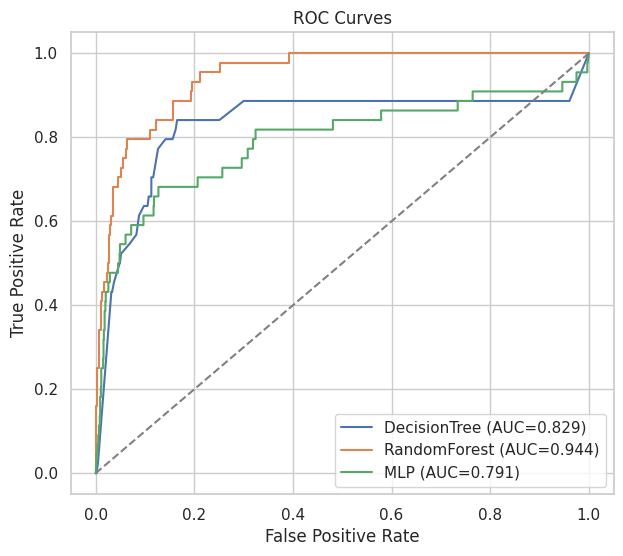

In [26]:
# ROC curves combined
plt.figure(figsize=(7,6))
for name, model in best_models.items():
    try:
        proba = model.predict_proba(X_test_s)[:,1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    except Exception:
        pass
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


Feature importances (from Random Forest)

In [27]:
if "RandomForest" in best_models:
    rf_model = best_models["RandomForest"]
    importances = pd.Series(rf_model.feature_importances_, index=X_train_res.columns).sort_values(ascending=False)
    display(importances.head(20))
    top5 = importances.head(5)
    print("\nTop 5 features:\n", top5)
else:
    print("RandomForest not in best models.")


,0
Borrowing dependency,0.077878
Retained Earnings to Total Assets,0.075210
Persistent EPS in the Last Four Seasons,0.070564
Pre-tax net Interest Rate,0.069548
Net Income to Stockholder's Equity,0.059071
Debt ratio %,0.056534
ROA(C) before interest and depreciation before interest,0.046759
Total income/Total expense,0.044840
Current Liabilities/Equity,0.040394
Equity to Liability,0.032331



Top 5 features:
 Borrowing dependency                       0.077878
Retained Earnings to Total Assets          0.075210
Persistent EPS in the Last Four Seasons    0.070564
Pre-tax net Interest Rate                  0.069548
Net Income to Stockholder's Equity         0.059071
dtype: float64


Save artifacts

In [28]:
os.makedirs("outputs", exist_ok=True)
joblib.dump(best_models, "outputs/best_models_dict.joblib")
joblib.dump(scaler, "outputs/scaler.joblib")
if "RandomForest" in best_models:
    joblib.dump(best_models["RandomForest"], "outputs/best_rf.joblib")
print("Saved model artifacts to ./outputs/")

Saved model artifacts to ./outputs/
